In [1]:
from pythologist_test_images import TestImages
from goodneighbors import GoodNeighbors
from tempfile import NamedTemporaryFile
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, scale, robust_scale
from plotnine import *

### prepare test data

In [2]:
cdf = TestImages().celldataframe('IrisSpatialFeatures')
cpi = TestImages().project('IrisSpatialFeatures')
cdf.db = cpi
cdf = cdf.threshold('CD8+','PD1').\
          threshold('OTHER','PD1').\
          rename_phenotype('OTHER PD1-','OTHER').\
          threshold('OTHER','PDL1').\
          threshold('SOX10+','PDL1').\
          rename_phenotype('OTHER PDL1-','OTHER PDL1- PD1-')

In [3]:
cdf.phenotypes

['CD8+ PD1+',
 'CD8+ PD1-',
 'OTHER PD1+',
 'OTHER PDL1+',
 'OTHER PDL1- PD1-',
 'SOX10+ PDL1+',
 'SOX10+ PDL1-']

In [4]:
cdf.scored_names

['PD1', 'PDL1']

In [5]:
cells = cdf.loc[:,['sample_name','frame_id','cell_index','x','y','phenotype_label']].dropna()
print(cells.shape)
cells.head()

(10120, 6)


,sample_name,frame_id,cell_index,x,y,phenotype_label
db_id,,,,,,
1,MEL3,0ec87a6aa3e944db8df7bc4f90854291,2,478,6,OTHER PDL1- PD1-
2,MEL3,0ec87a6aa3e944db8df7bc4f90854291,3,500,5,OTHER PDL1- PD1-
3,MEL3,0ec87a6aa3e944db8df7bc4f90854291,4,991,6,OTHER PDL1- PD1-
4,MEL3,0ec87a6aa3e944db8df7bc4f90854291,5,1246,6,CD8+ PD1-
5,MEL3,0ec87a6aa3e944db8df7bc4f90854291,6,915,7,OTHER PDL1- PD1-


In [6]:
cells['phenotype_label'].value_counts()

SOX10+ PDL1-        5160
OTHER PDL1- PD1-    2265
SOX10+ PDL1+        1774
OTHER PDL1+          378
CD8+ PD1+            338
OTHER PD1+           122
CD8+ PD1-             83
Name: phenotype_label, dtype: int64

### Execute the Neighborhood analysis

In [7]:
path = NamedTemporaryFile().name

In [8]:
gn = GoodNeighbors(path,mode='w',microns_per_pixel=0.496,verbose=True)
gn.set_cells(cells,groupby=['sample_name','frame_id'])
gn.calculate_neighbor_counts(radius=37.5,units='microns')
gn.calculate_fractions(scaler=None)
gn.calculate_clusters(5)

Max distance is 151.20967741935485
Calculating distances for sample_name                                MEL3
frame_id       0ec87a6aa3e944db8df7bc4f90854291
Name: 0, dtype: object
Calculating distances for sample_name                                MEL3
frame_id       c0e230c4db0a4cc481a726d7547a1af4
Name: 2623, dtype: object
Calculating distances for sample_name                                MEL2
frame_id       214a07c729324148adc9eec4db1b84b3
Name: 5508, dtype: object
Calculating distances for sample_name                                MEL2
frame_id       ce1f5cd091974eaba5c5de628c606efe
Name: 7778, dtype: object


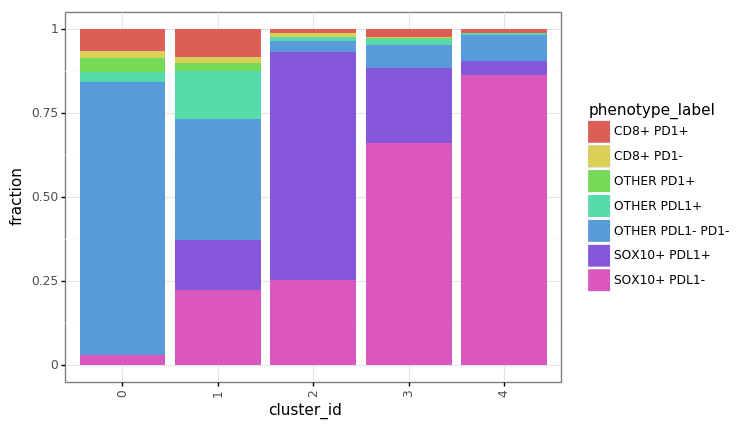

<ggplot: (-9223372036541527208)>

In [9]:
cnts,g = gn.get_cluster_composition()
g

executing TSNE decomposition on 1000 cells
Using sklearn TSNE


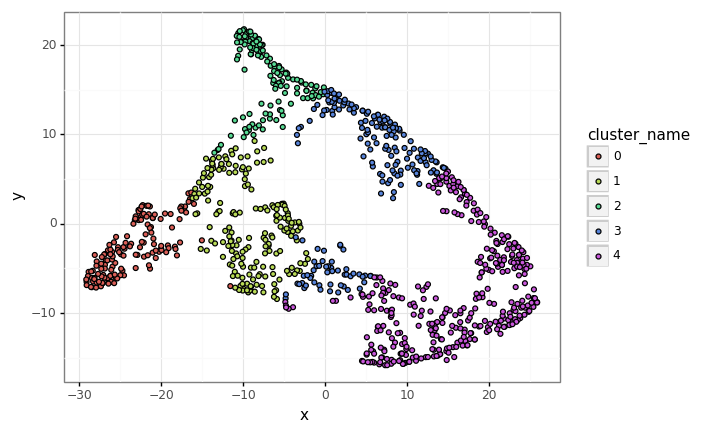

<ggplot: (314103816)>

In [10]:
gn.calculate_TSNE(sample=1000,perplexity=60,n_iter=2000,learning_rate=50)
(ggplot(gn.tsne,aes(x='x',y='y',fill='cluster_name'))
 + geom_point()
 + theme_bw()
)

In [11]:
gn.tsne.head()

,db_id,x,y,cluster_id,k,sample_name,frame_id,cluster_name
0,7763,1.322204,-8.657526,4,5,MEL2,214a07c729324148adc9eec4db1b84b3,4
1,8596,-22.494223,0.719171,0,5,MEL2,ce1f5cd091974eaba5c5de628c606efe,0
2,8862,-22.094873,-3.715375,0,5,MEL2,ce1f5cd091974eaba5c5de628c606efe,0
3,4249,19.650152,0.715701,4,5,MEL3,c0e230c4db0a4cc481a726d7547a1af4,4
4,6681,8.020090,-10.466765,4,5,MEL2,214a07c729324148adc9eec4db1b84b3,4


In [12]:
gn.label_clusters({'STROMA':[0],'MARGIN':[1],'PD-L1 High Tumor':[2,3],'PD-L1 Low Tumor':[4]})

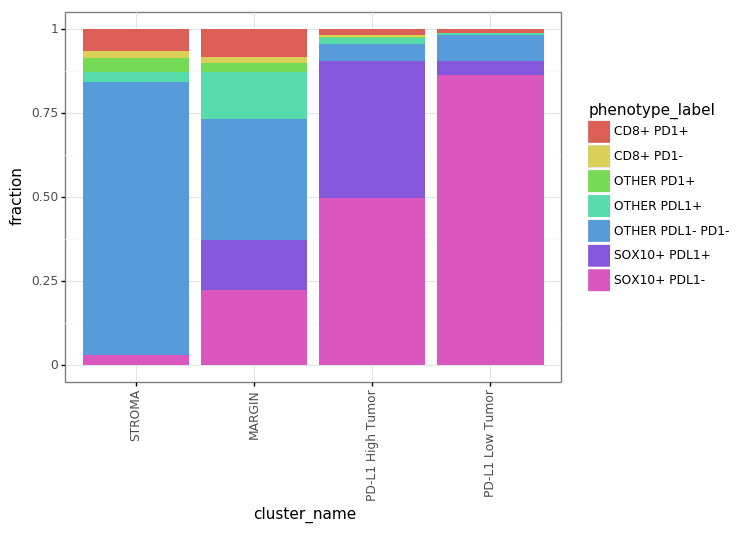

<ggplot: (-9223372036537681720)>

In [13]:
cnts,g = gn.get_cluster_composition(label='cluster_name')
g

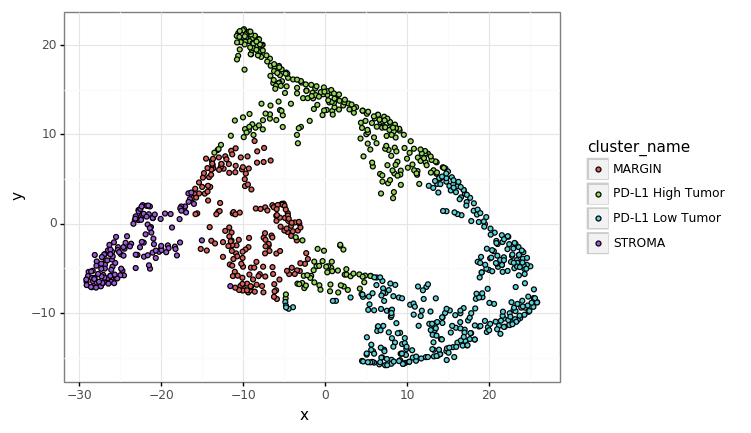

<ggplot: (314222491)>

In [14]:
(ggplot(gn.tsne,aes(x='x',y='y',fill='cluster_name'))
 + geom_point()
 + theme_bw()
)

In [18]:
gn.clusters.head()

,cluster_id,k,x,y,phenotype_label,sample_name,frame_id,cluster_name
db_id,,,,,,,,
1,0,5,478,6,OTHER PDL1- PD1-,MEL3,0ec87a6aa3e944db8df7bc4f90854291,STROMA
2,0,5,500,5,OTHER PDL1- PD1-,MEL3,0ec87a6aa3e944db8df7bc4f90854291,STROMA
3,0,5,991,6,OTHER PDL1- PD1-,MEL3,0ec87a6aa3e944db8df7bc4f90854291,STROMA
4,0,5,1246,6,CD8+ PD1-,MEL3,0ec87a6aa3e944db8df7bc4f90854291,STROMA
5,0,5,915,7,OTHER PDL1- PD1-,MEL3,0ec87a6aa3e944db8df7bc4f90854291,STROMA


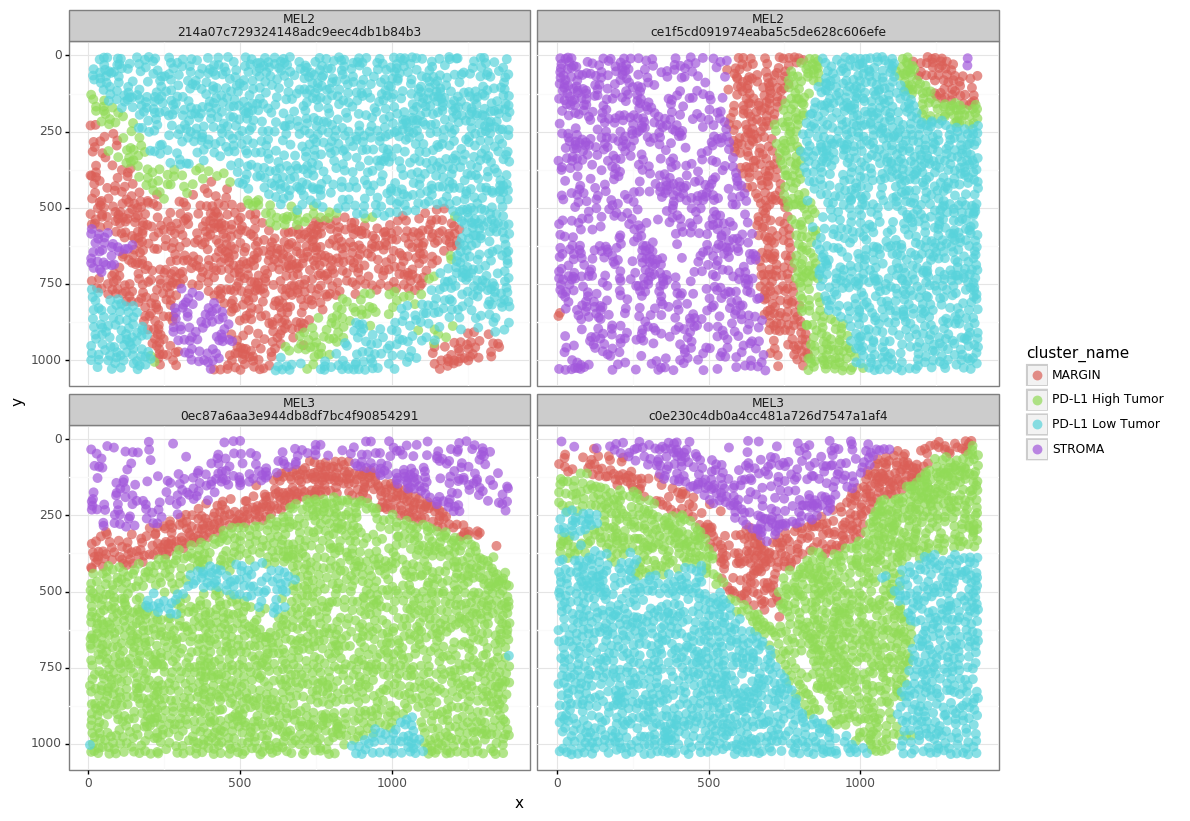

<ggplot: (323532699)>

In [26]:
shape = cdf.iloc[0]['frame_shape']
(ggplot(gn.clusters,aes(x='x',y='y',fill='cluster_name'))
 + geom_point(size=4,alpha=0.7,stroke=0)
 + facet_wrap(['sample_name','frame_id'])
 + theme_bw()
 + theme(figure_size=(12,12),aspect_ratio=shape[0]/shape[1])
 + scale_y_reverse()
)

In [27]:
X = gn.fractions

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from __future__ import print_function

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)


range_n_clusters = [2,3,4,5,6,7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    ## 2nd Plot showing the actual clusters formed
    #colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    #ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
    #            c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.4719428032700147
For n_clusters = 3 The average silhouette_score is : 0.5013703719255789
